In [1]:
"""Configuration constants"""

SEED = 42
DATA_PATH = '../../data'
OUTS_PATH = '../outs/nk_zkc_zkw/'


In [2]:
"""Imports"""

import os
import pandas as pd
import seaborn as sns


In [3]:
"""Functions"""

def read_solution_file(name, root):
    """Read solution csv to pandas dataframe"""
    dataset, n, *_ = name.split('_')
    columns = [('idx', ''), ('n', ''), ('value', '')]
    columns.extend([('item', i) for i in range(int(n))])
    columns.append(('trailing', ''))
    data = pd.read_csv(os.path.join(root, name), sep=' ', header=None, names=columns)
    data.insert(0, ('dataset', ''), dataset)
    data.insert(0, ('source', ''), root.split('/')[-1])
    data.columns = pd.MultiIndex.from_tuples(data.columns)
    return data

def read_metadata_file(name, root):
    """Read metadata csv to pandas dataframe"""
    
    data = pd.read_csv(os.path.join(root, name), sep=' ', header=None)

    # Rename columns at the beginning [('idx', ''), ('n', ''),...]
    first_cols = {
        data.columns[0]: ('idx',''),
        data.columns[1]: ('n',''),
    }
    # Rename columns at the end [..., ('total_eval',''), ('seconds', '')]
    last_cols = {
        data.columns[-3]: ('total_eval',''),
        data.columns[-2]: ('tabu_list', ''),
        data.columns[-1]: ('seconds',''),
    }
    # Rename steps [k,k+1,...,k+n] -> [('step', 0), ('step',1), ..., ('step',n)]
    step_cols = {n: ('step', i) for i, n in enumerate(data.columns[len(first_cols) : -len(last_cols)])}

    # Renaming itself
    data = data.rename({**first_cols, **step_cols, **last_cols}, axis=1)
    
    # Insert source and dataset columns at the beginning
    data.insert(0, ('dataset',''), name.split('_')[0])
    data.insert(0, ('source', ''), root.split('/')[-1])

    # Make columns multiindex
    data.columns = pd.MultiIndex.from_tuples(data.columns)

    return data

def calculate_rel_error(computed_value, optimal_value):
    """Calculate relative error"""
    difference = abs(optimal_value - computed_value)
    max_value = max(optimal_value, computed_value)
    assert(max_value >= 0), f"max_value = {max_value}"
    rel_error = min(difference/max_value, 1) if (max_value > 0) else 0
    return rel_error            


In [4]:
%%time
"""Read solution files to solution dataframe""" # Wall time: 1.75 s

soln_dfs = [None, None]

for pos, source in enumerate((DATA_PATH, OUTS_PATH)):
    for root, dirs, files in os.walk(source, topdown=False):
        for name in sorted(files):
            if int(name.split('_')[1]) <= 30:
                continue
            if ("soln" in name):
                if soln_dfs[pos] is None:
                    soln_dfs[pos] = read_solution_file(name, root)
                else:
                    soln_dfs[pos] = pd.concat([soln_dfs[pos], read_solution_file(name, root)], ignore_index=True)

opt_df, soln_df = soln_dfs

opt_df = opt_df.drop([('trailing', '')], axis=1)
soln_df = soln_df.drop([('trailing', '')], axis=1)

display(
    'opt_df', opt_df.shape,
    opt_df.sample(n=5, random_state=SEED),

    'soln_df', soln_df.shape,
    soln_df.sample(n=5, random_state=SEED),
)

'opt_df'

(4597, 45)

dataset  idx item                       ...                           \
                     0  1  2  3  4  5  6  7  ...   33   34   35   36   37   
1393      nk  394    1  0  1  0  1  1  0  1  ...  0.0  1.0  1.0  1.0  NaN   
2936     zkc  268    1  1  1  1  1  1  1  0  ...  1.0  1.0  NaN  NaN  NaN   
1880      nk  381    0  1  1  0  0  1  1  0  ...  1.0  1.0  0.0  0.0  0.0   
505       nk    6    0  0  0  0  0  0  0  0  ...  0.0  0.0  NaN  NaN  NaN   
869       nk  370    1  0  1  1  0  1  1  1  ...  1.0  1.0  NaN  NaN  NaN   

                 n source  value  
       38   39                    
1393  NaN  NaN  37     nk  45085  
2936  NaN  NaN  35    zkc  33884  
1880  1.0  0.0  40     nk  34977  
505   NaN  NaN  35     nk   4650  
869   NaN  NaN  35     nk  36404  

[5 rows x 45 columns]

'soln_df'

(24780, 45)

dataset  idx item                       ...                           \
                      0  1  2  3  4  5  6  7  ...   33   34   35   36   37   
11063     zkc  304    1  1  0  1  0  0  1  1  ...  0.0  1.0  NaN  NaN  NaN   
4189       nk   60    1  1  1  1  0  0  0  1  ...  NaN  NaN  NaN  NaN  NaN   
20101     zkc   82    1  1  1  1  0  0  1  1  ...  0.0  1.0  0.0  0.0  1.0   
24512     zkc  363    1  1  1  1  0  1  1  1  ...  1.0  1.0  0.0  0.0  1.0   
20629     zkw  918    0  0  0  0  0  0  0  0  ...  0.0  0.0  1.0  0.0  0.0   

                  n        source  value  
        38   39                           
11063  NaN  NaN  35  tabu_n^2_n^2  29770  
4189   NaN  NaN  32   tabu_n_sqrt  37216  
20101  0.0  1.0  40   tabu_n_cbrt  36513  
24512  0.0  1.0  40      tabu_n_n  37651  
20629  0.0  0.0  40   tabu_n_cbrt   4867  

[5 rows x 45 columns]

CPU times: user 1.4 s, sys: 141 ms, total: 1.54 s
Wall time: 1.55 s


In [5]:
%%time
"""Read metadata files into metadata dataframe""" # Wall time: 13.4 s

meta_df = None

for root, dirs, files in os.walk(OUTS_PATH, topdown=False):
    for name in sorted(files):
        if int(name.split('_')[1]) < 30:
            continue
        if ("meta" in name):
            if meta_df is None:
                meta_df = read_metadata_file(name, root)
            else:
                meta_df = pd.concat([meta_df, read_metadata_file(name, root)], ignore_index=True)

display(
    'meta_df', meta_df.shape,
    meta_df.sample(n=5, random_state=SEED),
)

'meta_df'

(25821, 1608)

dataset  idx   n   seconds        source step                       \
                                                  0      1      2      3   
10444      nk  185  40  0.370776  tabu_n^2_n^2 -145  35190  37279  36878   
19075      nk   15  40  0.007144   tabu_n_cbrt -151  50498  50303  51164   
8396       nk  137  30  0.156086  tabu_n^2_n^2  -77  28851  29987  30630   
1808       nk  309  40  0.009777   tabu_n_div3  -69   3431   5384   7143   
8673       nk  414  30  0.155713  tabu_n^2_n^2 -834   -586   -372   -179   

              ...                                                        \
           4  ...     1593     1594     1595     1596     1597     1598   
10444  38926  ...  44986.0  44150.0  45151.0  44253.0  44958.0  44308.0   
19075  50911  ...      NaN      NaN      NaN      NaN      NaN      NaN   
8396   30453  ...      NaN      NaN      NaN      NaN      NaN      NaN   
1808    6814  ...      NaN      NaN      NaN      NaN      NaN      NaN   
8673   12106  ...      NaN      NaN      NaN      NaN      NaN      NaN   

                        tabu_list total_eval  
          1599     1600                       
10444  45206.0  44211.0      1600      64001  
19075      NaN      NaN         9       1601  
8396       NaN      NaN       900      27001  
1808       NaN      NaN        32       1601  
8673       NaN      NaN       900      27001  

[5 rows x 1608 columns]

CPU times: user 7.1 s, sys: 2.84 s, total: 9.94 s
Wall time: 10 s


In [6]:
%%time
"""Merge value from opt_df into soln_df as opt_value""" # Wall time: 85.6 ms

# Drop duplicated solution - we care only about the optimal value, not about the items in the soluiton
opt_df = opt_df.drop_duplicates(subset=[('dataset', ''), ('n', ''), ('idx', '')])
opt_df = opt_df[[('dataset', ''), ('n', ''), ('idx', ''), ('value', '')]].rename(columns={'value': 'opt_value'})

soln_df = soln_df.merge(opt_df, how='left', on=[('dataset', ''), ('n', ''), ('idx', '')])

display(
    'soln_df', soln_df.shape,
    soln_df.sample(n=5, random_state=SEED),
)

'soln_df'

(24780, 46)

dataset  idx item                       ...                           \
                      0  1  2  3  4  5  6  7  ...   34   35   36   37   38   
11063     zkc  304    1  1  0  1  0  0  1  1  ...  1.0  NaN  NaN  NaN  NaN   
4189       nk   60    1  1  1  1  0  0  0  1  ...  NaN  NaN  NaN  NaN  NaN   
20101     zkc   82    1  1  1  1  0  0  1  1  ...  1.0  0.0  0.0  1.0  0.0   
24512     zkc  363    1  1  1  1  0  1  1  1  ...  1.0  0.0  0.0  1.0  0.0   
20629     zkw  918    0  0  0  0  0  0  0  0  ...  0.0  1.0  0.0  0.0  0.0   

             n        source  value opt_value  
        39                                     
11063  NaN  35  tabu_n^2_n^2  29770     31025  
4189   NaN  32   tabu_n_sqrt  37216     39251  
20101  1.0  40   tabu_n_cbrt  36513     38038  
24512  1.0  40      tabu_n_n  37651     38693  
20629  0.0  40   tabu_n_cbrt   4867      4867  

[5 rows x 46 columns]

CPU times: user 83.6 ms, sys: 6.22 ms, total: 89.8 ms
Wall time: 93.6 ms


In [7]:
%%time
"""Merge solution with metadata dataframe""" # Wall time: 487 ms

outs_df = soln_df.merge(meta_df, how='left', on=[('source',''), ('dataset',''), ('n', ''), ('idx', '')])

display(
    'outs_df', outs_df.shape,
    outs_df.sample(n=5, random_state=SEED)
)

'outs_df'

(24780, 1650)

dataset  idx item                       ... step                      \
                      0  1  2  3  4  5  6  7  ... 1593 1594 1595 1596 1597   
11063     zkc  304    1  1  0  1  0  0  1  1  ...  NaN  NaN  NaN  NaN  NaN   
4189       nk   60    1  1  1  1  0  0  0  1  ...  NaN  NaN  NaN  NaN  NaN   
20101     zkc   82    1  1  1  1  0  0  1  1  ...  NaN  NaN  NaN  NaN  NaN   
24512     zkc  363    1  1  1  1  0  1  1  1  ...  NaN  NaN  NaN  NaN  NaN   
20629     zkw  918    0  0  0  0  0  0  0  0  ...  NaN  NaN  NaN  NaN  NaN   

                     tabu_list total_eval  
      1598 1599 1600                       
11063  NaN  NaN  NaN      1225      42876  
4189   NaN  NaN  NaN        25       1025  
20101  NaN  NaN  NaN        14       1601  
24512  NaN  NaN  NaN        40       1601  
20629  NaN  NaN  NaN        23       1601  

[5 rows x 1650 columns]

CPU times: user 325 ms, sys: 147 ms, total: 471 ms
Wall time: 467 ms


In [8]:
%%time
"""Compute relative error""" # Wall time: 491 ms

outs_df[('rel_error', '')] = outs_df[[('value', ''), ('opt_value', '')]].apply(
    lambda x: calculate_rel_error(x[0], x[-1]), axis=1
)

display(
    'outs_df', outs_df.shape,
    outs_df.sample(n=5, random_state=SEED)
)

'outs_df'

(24780, 1651)

dataset  idx item                       ... step                      \
                      0  1  2  3  4  5  6  7  ... 1594 1595 1596 1597 1598   
11063     zkc  304    1  1  0  1  0  0  1  1  ...  NaN  NaN  NaN  NaN  NaN   
4189       nk   60    1  1  1  1  0  0  0  1  ...  NaN  NaN  NaN  NaN  NaN   
20101     zkc   82    1  1  1  1  0  0  1  1  ...  NaN  NaN  NaN  NaN  NaN   
24512     zkc  363    1  1  1  1  0  1  1  1  ...  NaN  NaN  NaN  NaN  NaN   
20629     zkw  918    0  0  0  0  0  0  0  0  ...  NaN  NaN  NaN  NaN  NaN   

                tabu_list total_eval rel_error  
      1599 1600                                 
11063  NaN  NaN      1225      42876  0.040451  
4189   NaN  NaN        25       1025  0.051846  
20101  NaN  NaN        14       1601  0.040091  
24512  NaN  NaN        40       1601  0.026930  
20629  NaN  NaN        23       1601  0.000000  

[5 rows x 1651 columns]

CPU times: user 398 ms, sys: 22.1 ms, total: 420 ms
Wall time: 416 ms


In [9]:
%%time
"""Create solution progress visualization dataframe""" # Wall time: 11.3 s

prog_df = outs_df[['source', 'dataset', 'n', 'idx', 'opt_value', 'step']]

# Take last level of multiindex if it is not empty, else take the first level
prog_df.columns = [tup[-1] if tup[-1] != '' else tup[0] for tup in prog_df.columns.to_flat_index()]

prog_df = pd.melt(
    prog_df, id_vars=['source', 'dataset', 'n', 'idx', 'opt_value'],
    var_name='step', value_name='step_value',
)

# Drow rows with NaN step_value (shape without this drop (8278771, 6))
prog_df = prog_df.dropna(subset=['step_value'])

# sns.lineplot(x='step', y='step_value', hue='source', data=prog_df)

display(
    'prog_df', prog_df.shape,
    prog_df.sample(n=5, random_state=SEED),
)

'prog_df'

(6153900, 7)

,source,dataset,n,idx,opt_value,step,step_value
223692,tabu_n_div3,nk,35,173,38293,9,38293.0
31036715,tabu_n^2_n^2,zkc,40,396,34914,1252,32687.0
24716630,tabu_n^2_n^2,zkc,35,211,28170,997,25957.0
14333072,tabu_n^2_n^2,nk,40,473,35836,578,31866.0
13067658,tabu_n^2_n^2,nk,32,339,34099,527,32460.0


CPU times: user 3.73 s, sys: 1.26 s, total: 4.99 s
Wall time: 5.07 s


In [25]:
%%time
"""Compute rel_error for every step""" # Wall time: 1min 15s

prog_df['rel_error'] = prog_df[['step_value', 'opt_value']].apply(
        lambda x: calculate_rel_error(x[0], x[-1]), axis=1
)

display(
    'prog_df', prog_df.shape,
    prog_df.sample(n=5, random_state=SEED),
)

'prog_df'

(6153900, 8)

,source,dataset,n,idx,opt_value,step,step_value,rel_error
223692,tabu_n_sqrt,nk,35,173,38293,9,38293.0,0.000000
31036715,tabu_n^2_n^2,zkc,40,396,34914,1252,32687.0,0.063785
24716630,tabu_n^2_n^2,zkc,35,211,28170,997,25957.0,0.078559
14333072,tabu_n^2_n^2,nk,40,473,35836,578,31866.0,0.110782
13067658,tabu_n^2_n^2,nk,32,339,34099,527,32460.0,0.048066


CPU times: user 1min 14s, sys: 919 ms, total: 1min 15s
Wall time: 1min 15s


CPU times: user 7min 26s, sys: 1.07 s, total: 7min 27s
Wall time: 7min 26s


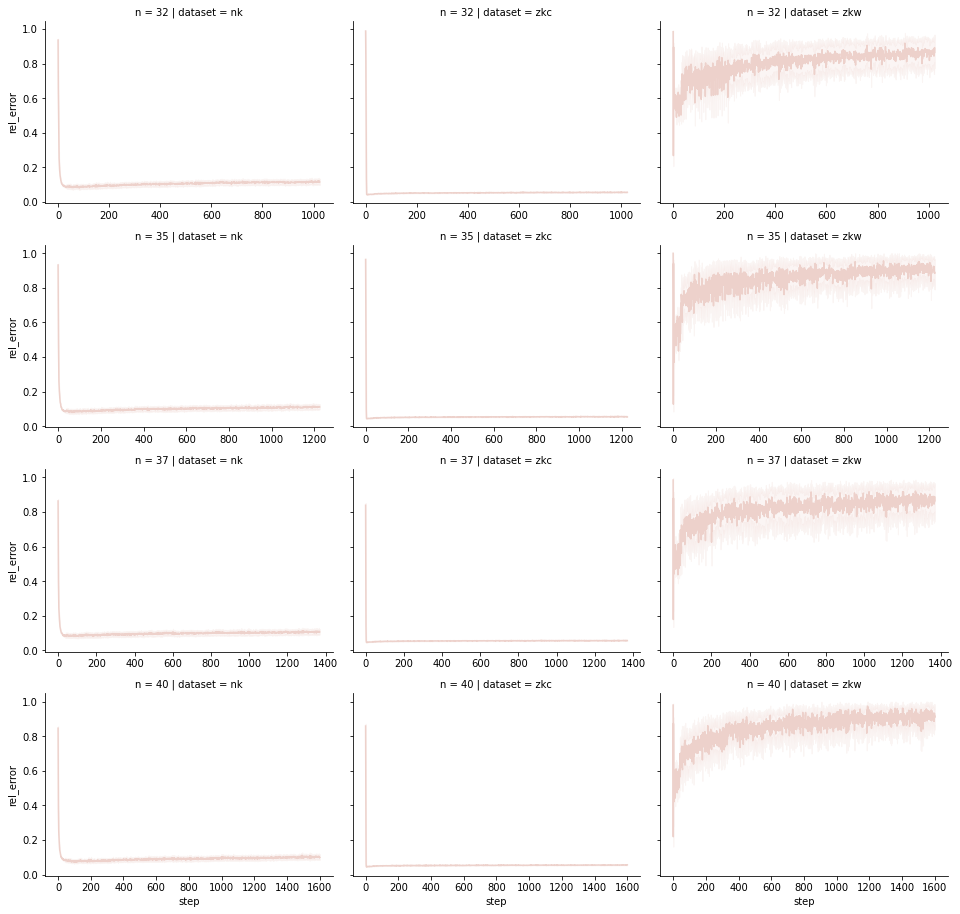

In [13]:
%%time
"""Relative error progress of tabu_n^2_n^2""" # Wall time: 7min 26s

prog_t_pwr2_df = prog_df[prog_df['source'] == 'tabu_n^2_n^2']

# Create facetgrid 'dataset' columns, 'rel_error' rows
g = sns.FacetGrid(col="dataset", row='n', data=prog_df,
        sharey=True, sharex=False, height=3.2, aspect=1.4,
)

# Visualize rel_error progress by every step
fig = g.map(sns.lineplot, 'step', 'rel_error', 'n')

# Save the figure
fig.savefig('../results/figures/tmp/rel_error_progress_by_step_m_pwr2_t_pwr2')

CPU times: user 11.6 s, sys: 164 ms, total: 11.7 s
Wall time: 11.4 s


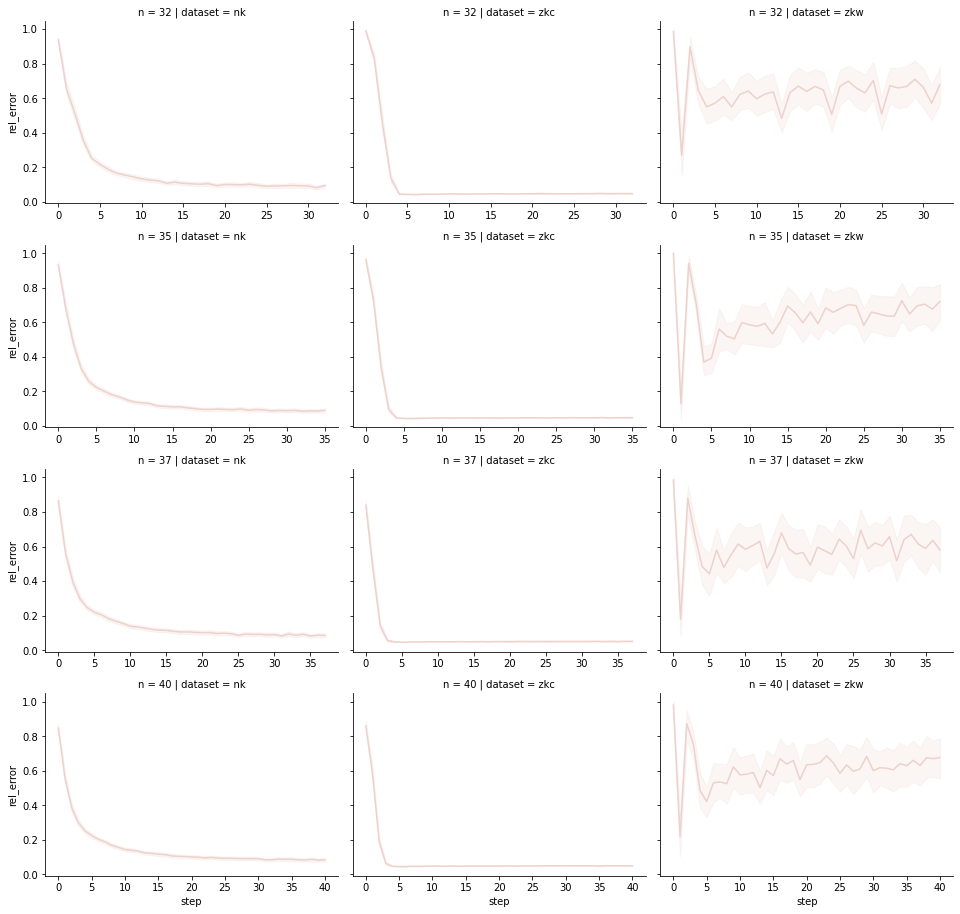

In [12]:
%%time
"""Relative error progress of tabu_n_n""" # Wall time: 11.4 s

prog_n_n_df = prog_df[prog_df['source'] == 'tabu_n_n']

# Create facetgrid 'dataset' columns, 'n' rows
g = sns.FacetGrid(col="dataset", row='n', data=prog_n_n_df,
        sharey=True, sharex=False, height=3.2, aspect=1.4,
)

# Visualize rel_error progress by every step
fig = g.map(sns.lineplot, 'step', 'rel_error', 'n')

# Save the figure
fig.savefig('../results/figures/tmp/rel_error_progress_by_step_m_n_t_n')

In [10]:
%%time
"""Create dataframe for relative error visualization by tabu tenure""" # Wall time: 125 ms

metrics_df = outs_df[outs_df['source'] != 'tabu_n^2_n^2'][[
        ('source', ''),
        ('dataset', ''),
        ('n', ''),
        ('rel_error', ''),
        ('tabu_list', ''),
        ('seconds', ''),
]]

# Drop empty level
metrics_df.columns = metrics_df.columns.droplevel(-1)

# Convert source column into ordinal type
# display(outs_df['source'].unique()) # Show all sources
metrics_df['source'] = metrics_df['source'].astype(pd.CategoricalDtype(categories=[
    'tabu_n_cbrt', 
    'tabu_n_sqrt', 
    'tabu_n_n_by_3', 
    'tabu_n_n_by_2', 
    'tabu_n_n', 
], ordered=True))

# Group data by 'dataset' and 'n'
metrics_df = metrics_df.groupby(['source', 'dataset', 'n']).agg(['min', 'mean', 'max'])

# Flatten rows multiindex 
metrics_df = metrics_df.reset_index()

# From [('rel_error', 'max'), ('rel_error', ...), ('seconds', 'mean') ...] -> ['metric', 'statistic']
metrics_df = pd.melt(metrics_df, id_vars=['source', 'dataset', 'n'],
        var_name=['metric', 'statistic'], value_name='value',
)

display(
    'metrics_df', metrics_df.shape,
    metrics_df.sample(n=5, random_state=42)
)

'metrics_df'

(540, 6)

,source,dataset,n,metric,statistic,value
229,tabu_n_n,nk,35,tabu_list,min,35.000000
73,tabu_n_sqrt,nk,35,rel_error,mean,0.045486
521,tabu_n_n_by_2,zkc,35,seconds,max,NaN
86,tabu_n_n_by_3,nk,37,rel_error,mean,NaN
469,tabu_n_n,nk,35,seconds,mean,0.007434


CPU times: user 170 ms, sys: 35.1 ms, total: 205 ms
Wall time: 237 ms


CPU times: user 1.67 s, sys: 155 ms, total: 1.83 s
Wall time: 1.58 s


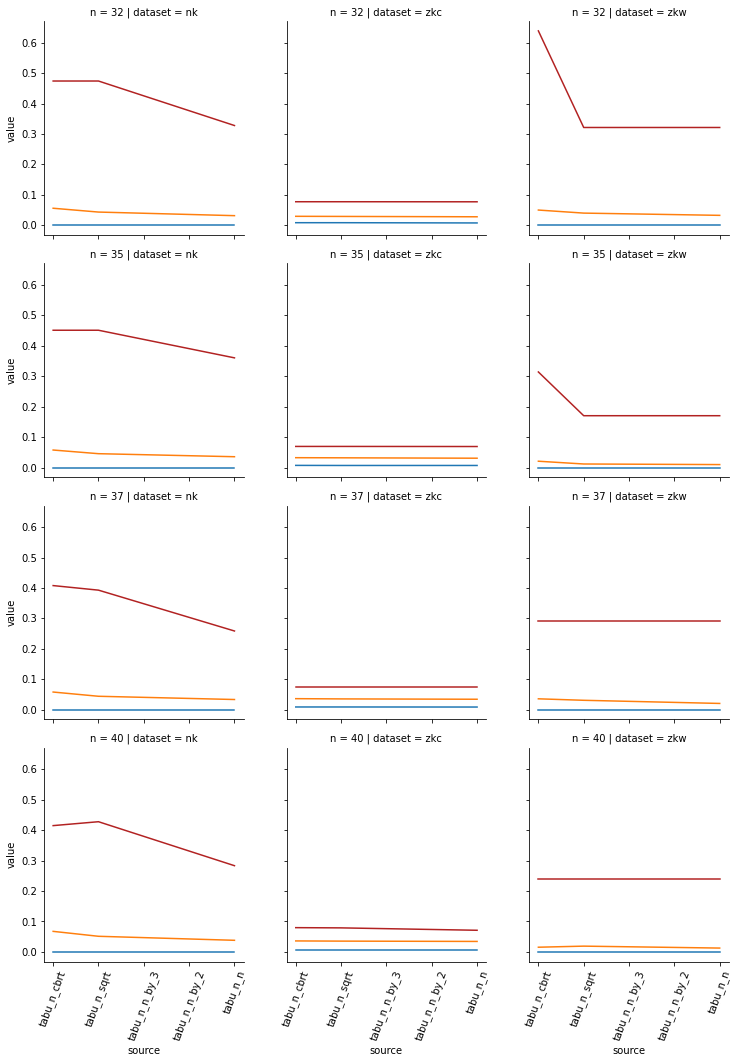

In [11]:
%%time
"""Visualize relative error""" # Wall time: 2.28 s

rel_error_df = metrics_df[metrics_df['metric'] == 'rel_error']

# Create facetgrid 'dataset' columns, 'rel_error' rows
g = sns.FacetGrid(col='dataset', row='n', data=rel_error_df,
        sharey=True, sharex=True, height=3.5
) # hue='statistic'

# Visualize relative error as lineplot
fig = g.map(sns.lineplot, 'source', 'value', 'statistic', 
        sort= False, hue_order=['max', 'mean', 'min'], palette=['firebrick', 'tab:orange', 'tab:blue']
)
g.set_xticklabels(rotation=70)

fig.savefig('../results/figures/tmp/rel_error_by_tabu_tenure_NEW')

CPU times: user 1.88 s, sys: 136 ms, total: 2.02 s
Wall time: 1.72 s


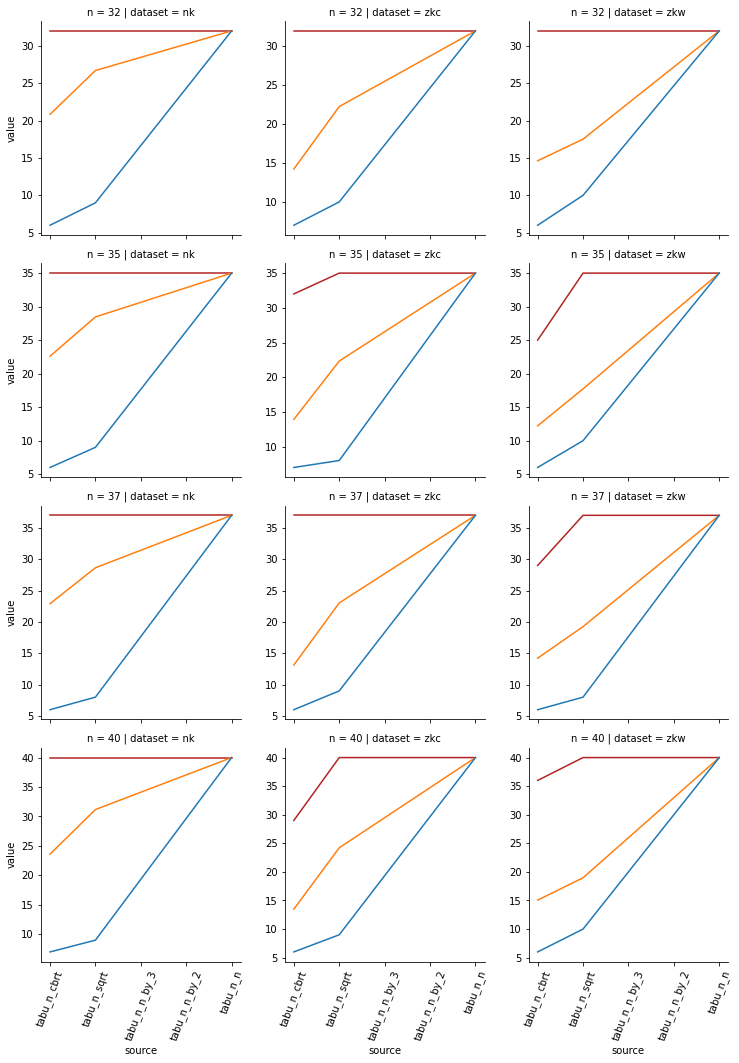

In [12]:
%%time
"""Visualize visited configurations""" # Wall time: 2.54 s

rel_error_df = metrics_df[metrics_df['metric'] == 'tabu_list']

# Create facetgrid 'dataset' columns, 'tabu_list' in rows
g = sns.FacetGrid(col='dataset', row='n', data=rel_error_df,
        sharey=False, sharex=True, height=3.5
) # hue='statistic'

# Visualize visited configurations as lineplot
fig = g.map(sns.lineplot, 'source', 'value', 'statistic', 
        sort= False, hue_order=['max', 'mean', 'min'], palette=['firebrick', 'tab:orange', 'tab:blue']
)
g.set_xticklabels(rotation=70)

fig.savefig('../results/figures/tmp/visited_configurations_by_tabu_tenure_NEW')

CPU times: user 1.72 s, sys: 145 ms, total: 1.86 s
Wall time: 1.56 s


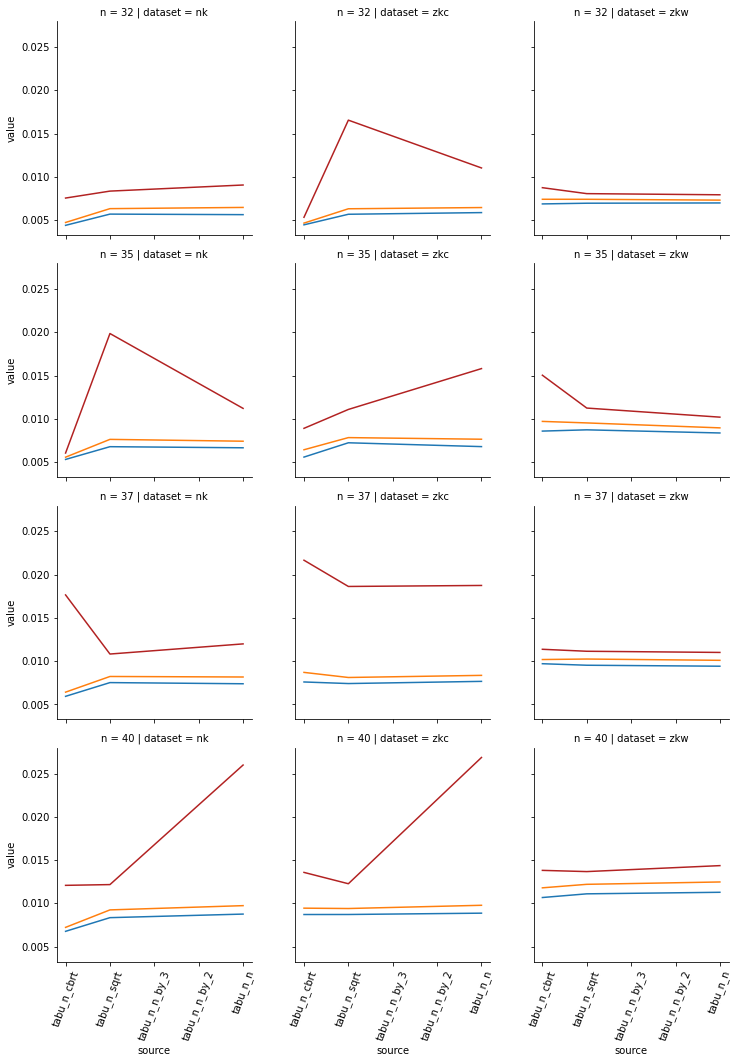

In [14]:
%%time
"""Visualize elapsed CPU time""" # Wall time: 2.83 s

rel_error_df = metrics_df[metrics_df['metric'] == 'seconds']


# Create facetgrid 'dataset' columns, 'seconds' rows
g = sns.FacetGrid(col='dataset', row='n', data=rel_error_df,
        sharey=True, sharex=True, height=3.5
) # hue='statistic'

# Visualize elapsed CPU time as lineplot
fig = g.map(sns.lineplot, 'source', 'value', 'statistic', 
        sort= False, hue_order=['max', 'mean', 'min'], palette=['firebrick', 'tab:orange', 'tab:blue']
)
g.set_xticklabels(rotation=70)

fig.savefig('../results/figures/tmp/elapsed_cpu_time_by_tabu_tenure_NEW')